# Setting Up Environment

In [1]:
import gym

## Cartpole Environment

In [2]:
env = gym.make('CartPole-v0')

The rendered window env might stay unresponsive and some say this is due to jupyter notebook visualization problems.  
Looking for a way to solve this.

Using GIF looks like one solution : https://rrbb014.tistory.com/44#openai-gym%EC%9D%84-jupyter-notebook%ED%99%98%EA%B2%BD%EC%97%90%EC%84%9C-%EC%8B%A4%ED%96%89%ED%95%98%EA%B8%B0-headless-playing

In [3]:
env.reset()
# let's see 10 timesteps with random action
for _ in range(10):
    # env.render()
    observation, reward, done, info = env.step(env.action_space.sample())
    print(observation, reward, done, info)
    if done:
        break
# env.close()

[-0.04116347  0.1556333  -0.04725857 -0.30391526] 1.0 False {}
[-0.0380508  -0.03878441 -0.05333687 -0.02650315] 1.0 False {}
[-0.03882649 -0.23310252 -0.05386694  0.24888588] 1.0 False {}
[-0.04348854 -0.42741546 -0.04888922  0.52410334] 1.0 False {}
[-0.05203685 -0.23164079 -0.03840715  0.2164245 ] 1.0 False {}
[-0.05666967 -0.03599143 -0.03407866 -0.08812205] 1.0 False {}
[-0.0573895  -0.23060875 -0.0358411   0.19361724] 1.0 False {}
[-0.06200167 -0.42520016 -0.03196876  0.47478187] 1.0 False {}
[-0.07050567 -0.6198564  -0.02247312  0.75721985] 1.0 False {}
[-0.0829028  -0.81466156 -0.00732872  1.0427473 ] 1.0 False {}


## Visualizing results

When the whole training is going on, the graph will be the mean survived timesteps for each epochs.

And the loss graph.

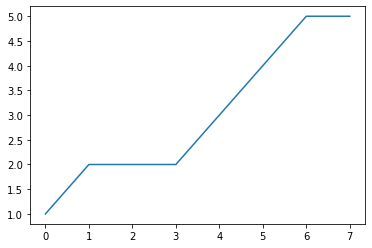

In [4]:
import matplotlib.pyplot as plt
plt.plot([1,2,2,2,3,4,5,5]);

## Model(for policy)

In [5]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np

Simple Linear NN for the policy. It is from a code in CS285 lecture 3, except it uses softmax at the output layer.

In [6]:
class Net(nn.Module):
    def __init__(self, input_size=4, output_size=2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x      

In [7]:
net = Net()
print(net)

# example of input
print(net(torch.tensor([[1., 2., 3., 4.], [2., 3., 2., 2.]])))

Net(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
tensor([[0.4483, 0.5517],
        [0.4801, 0.5199]], grad_fn=<SoftmaxBackward0>)


# Mathematics

$$
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \sum_{t=1}^{T} \nabla_\theta \log{\pi_\theta \left( a_{i,t} | s_{i,t} \right)}  \left( \sum_{t^\prime=t}^{T} r\left( s_{i,t}, a_{i,t} \right) \right) \\
J(\theta) = E_{\tau~p_\theta(\tau)}\left[ \sum_{t}r(s_t, a_t) \right] \approx \frac{1}{N}\sum_i\sum_{t}r(s_{i,t}, a_{i,t}) \\
\tilde{J}(\theta) \approx \frac{1}{N}\sum_{i=1}^N\sum_{t=1}^T \log{\pi_\theta \left( a_{i,t} | s_{i,t} \right)} \hat{Q}_{i,t} \\
$$

$-\tilde{J}(\theta)$ will be used as the loss function

$$
\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta) \\ = \theta - \alpha \nabla_\theta (-J(\theta))
$$

# The codes that will run to train

In [29]:
# number of samples(trajectories) for each iteration
N = 1000

# T(max length of the trajectory)
max_traj_len = 100 

# The policy object
net = Net()

## run the policy to create N samples

All information about samples will be stored in a list `samples`

The final shape of the list `samples` will be

__[nth_trajectory] [state, action, reward, q_value(reward to go)]__

In [30]:
from tqdm import tqdm # to visualize the progress

# new samples for every update, because VPG is an On-policy algorithm
samples = []

for sample_i in tqdm(range(N)):
    # initial state
    observation = env.reset()
    one_traj = []
    for traj_step in range(max_traj_len):
        # rolling out the policy to get actions
        action = net(torch.from_numpy(observation)).detach().numpy().argmax()
        observation, reward, done, info = env.step(action)
        
        # append the [s, a, r] in a list
        one_traj.append([observation, action, reward])
        if done or traj_step == (max_traj_len - 1):
            # append the trajectory in a list
            samples.append(one_traj)
            break

print('one trajectory looks like this')
for traj in samples[0]:
    print(traj)

100%|██████████| 1000/1000 [00:02<00:00, 396.25it/s]


one trajectory looks like this
[array([-0.00102793, -0.19694796, -0.04403863,  0.2293415 ], dtype=float32), 0, 1.0]
[array([-0.00496689, -0.39141384, -0.03945181,  0.50781435], dtype=float32), 0, 1.0]
[array([-0.01279516, -0.58595836, -0.02929552,  0.78780824], dtype=float32), 0, 1.0]
[array([-0.02451433, -0.78066593, -0.01353936,  1.0711325 ], dtype=float32), 0, 1.0]
[array([-0.04012765, -0.97560626,  0.0078833 ,  1.3595358 ], dtype=float32), 0, 1.0]
[array([-0.05963977, -1.1708262 ,  0.03507401,  1.6546743 ], dtype=float32), 0, 1.0]
[array([-0.08305629, -1.3663394 ,  0.0681675 ,  1.9580735 ], dtype=float32), 0, 1.0]
[array([-0.11038309, -1.5621147 ,  0.10732897,  2.27108   ], dtype=float32), 0, 1.0]
[array([-0.14162537, -1.7580606 ,  0.15275057,  2.5948017 ], dtype=float32), 0, 1.0]
[array([-0.17678659, -1.9540079 ,  0.2046466 ,  2.9300346 ], dtype=float32), 0, 1.0]
[array([-0.21586674, -2.14969   ,  0.2632473 ,  3.27718   ], dtype=float32), 0, 1.0]


## Getting the Q-values(reward to go)

$$
\hat{Q}_{i,t} = \sum^{T}_{t^\prime=t}{r\left( s_{i, t^\prime} , a_{i, t^\prime}\right )}
$$

In [12]:
# Getting the q-values(reward to go)
q_values = []
for sample in samples:
    temp = []
    for i in range(len(sample)):
        q = 0
        for t in range(i, len(sample)):
            q += sample[t][2] # Adding the reward for time t at current trajectory
        temp.append(q)
    q_values.append(temp)

# appending the q_values to the 'samples' list
for i in range(len(q_values)):
    for j in range(len(q_values[i])):
        samples[i][j].append(q_values[i][j])
        
        
        
print('Now, one trajectory looks like this')
for traj in samples[0]:
    print(traj)

Now, one trajectory looks like this
[array([ 0.03760169, -0.20999046, -0.00239286,  0.2592567 ], dtype=float32), 0, 1.0, 13.0]
[array([ 0.03340188, -0.40507817,  0.00279228,  0.55118394], dtype=float32), 0, 1.0, 12.0]
[array([ 0.02530031, -0.6002392 ,  0.01381595,  0.8447453 ], dtype=float32), 0, 1.0, 11.0]
[array([ 0.01329553, -0.79554695,  0.03071086,  1.1417407 ], dtype=float32), 0, 1.0, 10.0]
[array([-0.00261541, -0.60083956,  0.05354567,  0.8588449 ], dtype=float32), 1, 1.0, 9.0]
[array([-0.0146322 , -0.7966484 ,  0.07072257,  1.1678721 ], dtype=float32), 0, 1.0, 8.0]
[array([-0.03056517, -0.6025142 ,  0.09408002,  0.89817387], dtype=float32), 1, 1.0, 7.0]
[array([-0.04261545, -0.7987768 ,  0.11204349,  1.2188846 ], dtype=float32), 0, 1.0, 6.0]
[array([-0.05859099, -0.6052633 ,  0.13642119,  0.9633063 ], dtype=float32), 1, 1.0, 5.0]
[array([-0.07069626, -0.8019282 ,  0.1556873 ,  1.2955465 ], dtype=float32), 0, 1.0, 4.0]
[array([-0.08673482, -0.6090885 ,  0.18159823,  1.0553728 ],

In [13]:
# shape of the list 'samples' => [trajectory][state, action, reward, q_value(reward to go)]
# making a list(soon will be changed to tensors) for actions, states, q_values

actions = []
states = []
q_values = []
for sample in samples:
    for state, action, reward, q_value in sample:
        states.append(state)
        actions.append(action)
        q_values.append(q_value)

actions = torch.from_numpy(np.array(actions))
states = torch.from_numpy(np.array(states))
q_values = torch.from_numpy(np.array(q_values))
net_values = net(states).max(dim=1).values

## backprop

$$
\tilde{J}(\theta) \approx \frac{1}{N}\sum_{i=1}^N\sum_{t=1}^T \log{\pi_\theta \left( a_{i,t} | s_{i,t} \right)} \hat{Q}_{i,t} \\
$$

In [51]:
# loss function is -(J tilde) (on the equation above)
def loss_fn(net_val, q_val):
    return -(torch.sum(torch.log(net_val) * q_val, dim=-1)) / N

loss = loss_fn(net_values, q_values)

# loss = F.cross_entropy(net(states), actions)


# using Adam optimizer (because in the lecture it was mentioned to be okay)
# the learning rate is from the codes of lecture 3
optimizer = optim.Adam(net.parameters(), lr=1e-3)

optimizer.zero_grad()
loss.backward()
optimizer.step()

# All the codes for learning

In [34]:
import gym
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

class Net(nn.Module):
    def __init__(self, input_size=4, output_size=2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x  

env = gym.make('CartPole-v0')
N = 1000
max_traj_len = 100 # T
net = Net()
# number of iterations
epoch_size = 300

def loss_fn(net_val, q_val):
    return -(torch.sum(torch.log(net_val) * q_val)) / N

optimizer = optim.Adam(net.parameters(), lr=1e-3)

# to record the progress
lasted_times = [] # a list for mean lasted time for each sample
losses = []


for _ in tqdm(range(epoch_size)):
    samples = [] # new samples, because VPG is on policy algo
    
    # a list for lasted time for each sample
    one_epoch_lasted_times = []
    for sample_i in range(N):
        # initial state
        observation = env.reset()
        one_traj = []
        for traj_step in range(max_traj_len):
            action = net(torch.from_numpy(observation)).detach().numpy().argmax()
            observation, reward, done, info = env.step(action)
            one_traj.append([observation, action, reward])
            if done or traj_step == (max_traj_len - 1):
                samples.append(one_traj)
                one_epoch_lasted_times.append(traj_step + 1)
                break
    
    # appending the mean lasted time for each trajectory
    lasted_times.append(sum(one_epoch_lasted_times) / len(one_epoch_lasted_times))
                
    # Getting the q-values(reward to go)
    q_values = []
    for sample in samples:
        temp = []
        for i in range(len(sample)):
            q = 0
            for t in range(i, len(sample)):
                q += sample[t][2]
            temp.append(q)
        q_values.append(temp)
    
    # appending the q values to the samples list
    for i in range(len(q_values)):
        for j in range(len(q_values[i])):
            samples[i][j].append(q_values[i][j])
    
    # sample shape => [trajectory][state, action, reward, q_value(reward to go)]
    # make torch.tensors for actions, states, q_values
    actions = []
    states = []
    q_values = []
    for sample in samples:
        for state, action, reward, q_value in sample:
            states.append(state)
            actions.append(action)
            q_values.append(q_value)

    actions = torch.from_numpy(np.array(actions))
    states = torch.from_numpy(np.array(states))
    q_values = torch.from_numpy(np.array(q_values))
    net_values = net(states).max(dim=1).values
    
    loss = loss_fn(net_val=net_values, q_val=q_values)
    losses.append(loss.data.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 300/300 [08:47<00:00,  1.76s/it]


# Visualize the lasted time for Epochs

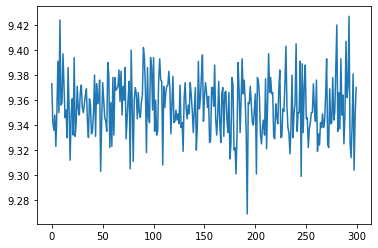

In [35]:
import matplotlib.pyplot as plt
plt.plot(lasted_times);

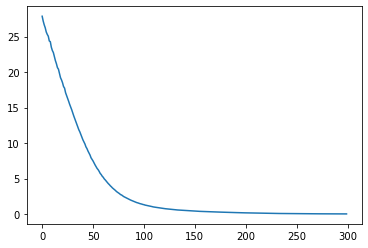

In [36]:
plt.plot(losses);